# Hierarchical Clustering

In [54]:
import pandas 
import nltk
import gensim
import spacy
import en_core_web_sm
import re
import numpy as np
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

Initialize spacy 'en' model.

In [29]:
nlp = en_core_web_sm.load(disable=['parser', 'ner']) # keeping only tagger component for efficiency

Load the relevant meta and text data of the active grants, while extracting the relevant data rows.

In [30]:
ninr19 = pandas.read_excel(r"./../data/NINR-2019-all-apps-with-RCDC.xlsx")
print(ninr19.head)


<bound method NDFrame.head of       Type Actv        Project              PI Name %tile Score  \
0        1  F31  NR018095-01A1        RALPHE, JANE      -    30   
1        1  F31  NR018099-01A1  FRASE, SUSAN ELAINE     -    39   
2        1  F31  NR018101-01A1     GRAVES, LETITIA      -    36   
3        1  F31  NR018104-01A1   BRODEN, ELIZABETH      -     -   
4        1  F31  NR018106-01A1     MULKEY, MALISSA      -    52   
...    ...  ...            ...                  ...   ...   ...   
1128     5  U2C    NR014637-07       KUTNER, JEAN S     -    30   
1129     7  R01    NR013520-08  TAYLOR, JACQUELYN Y     8    25   
1130     7  R01    NR014846-04         DONG, XINQI     12    23   
1131     7  R01    NR016957-02     DOWNS, CHARLES A    19    29   
1132     7  R01    NR017626-03        MISRA, DAWN P    13    34   

                                                  Title  Council  \
0     Body Temperature in the First Two Weeks of Lif...   201901   
1             Defining Charac

Remove empty texts and create text field consisting of title, abstract, and specific aims.

In [31]:
ninr19 = ninr19[pandas.notna(ninr19['Abstract Text (only)'])] # remove if abstract is empty
ninr19 = ninr19[ninr19['Abstract Text (only)'] != "-"] # remove rows with dashes
ninr19['text'] = ninr19['Title'].map(str) + " " + ninr19['Abstract Text (only)'].map(str) + " " + ninr19['SA Text'].map(str)

Clean up the text by stripping whitespace and keeping only letters.

In [32]:
ninr19['text'] = ninr19['text'].str.replace("[\n\xa0]", " ", regex=True).str.strip() # strip whitespace
ninr19['text'] = ninr19['text'].str.replace("[^A-Za-z ]+", "", regex=True) # keep only letters

Make all text lowercase.

In [33]:
ninr19['text'] = ninr19['text'].str.lower() # make all text lowercase

Only keep documents with unique text.

In [34]:
ninr19 = ninr19.drop_duplicates(subset=['text'])

Load stopwords.

In [35]:
with open("stopwords.txt") as f: # words loaded from local .txt file
    remove_words = [line.strip() for line in f if line.strip()]
    
print(remove_words)

['PAULWORDS', 'read', 'paramet', 'devic', 'detail', 'mab', 'calcul', 'research', 'user', 'communiti', 'support', 'dissemin', 'estim', 'method', 'ALAZWORDS', 'develop', 'aim', 'model', 'STOPWORDS', 'a', "a's", 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after', 'afterwards', 'again', 'against', "ain't", 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', "aren't", 'around', 'as', 'aside', 'ask', 'asking', 'associated', 'at', 'available', 'away', 'awfully', 'b', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'both', 'brief', 'but', 'by', 'c', "c'mon", "c's", 'came', 'can', "can't", 'cann

Split the texts into lists of words. Also check against stopwords of the word's stem and remove. Here we apply Snowball Stemming (http://snowball.tartarus.org/texts/introduction.html).

In [36]:
sno = nltk.stem.SnowballStemmer('english') # import from nltk library

def stem_sentences(text): # helper function
    tokens = text.split()
    split_text = [t for t in tokens if sno.stem(t) not in remove_words]
    return(split_text)

ninr19['text'] = ninr19['text'].apply(stem_sentences) # apply function for each document

Build a bigram model of the texts.

In [37]:
texts = ninr19.text.values.tolist() # creates text_values variable

bigram_phrases = gensim.models.Phrases(texts, min_count=5, threshold=100)
bigram_phraser = gensim.models.phrases.Phraser(bigram_phrases)
bigrams = [bigram_phraser[doc] for doc in texts] # form bigrams
print(len(bigrams))

1115


Lemmatize the words of the text, while only including nouns and verbs.

In [38]:
def lemmatization(texts, allowed_postags=['NOUN', 'VERB']): # helper fuction
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) # spacy function
        texts_out.append([token.lemma_ for token in doc]) #if token.pos_ in allowed_postags]) # This gets rid of many things
    return(texts_out)

In [43]:
texts = lemmatization(bigrams)

In [46]:
remove_words = []
with open("lemma_stopwords.txt") as f: # words loaded from local .txt file
    remove_words = [line.strip() for line in f if line.strip()]

for i in range(len(texts)):
    for remove_word in remove_words:
        if remove_word in texts[i]:
            texts[i] = list(filter(lambda a: a != remove_word, texts[i]))
            #print(remove_word) 

In [47]:
texts[1]

['define',
 'characteristics',
 'preterm_birth',
 'project_summary',
 'preterm_birth',
 'ptb',
 'affect',
 'birth',
 'responsible',
 'neonatal',
 'mortality',
 'morbidity',
 'spite',
 'decade',
 'ptb',
 'rate',
 'continue',
 'increase',
 'recognition',
 'risk',
 'factor',
 'cause',
 'ptb',
 'critical',
 'factor',
 'prediction',
 'prevention',
 'treatment',
 'ptb',
 'ability',
 'predict',
 'experience',
 'ptb',
 'hinder',
 'lack',
 'association',
 'objective',
 'markerstrait',
 'ptb',
 'include',
 'sociodemographic',
 'clinical',
 'characteristic',
 'date',
 'ptb',
 'define',
 'single',
 'outcome',
 'delivery',
 'prior',
 'week',
 'complete',
 'gestation',
 'recently',
 'reconceptualize',
 'ptb',
 'syndrome',
 'multiple',
 'pathology',
 'clinical',
 'phenotype',
 'critical',
 'gap',
 'knowledge',
 'ability',
 'accurately',
 'consistently',
 'define',
 'ptb',
 'clinical',
 'phenotype',
 'effort',
 'determine',
 'causal',
 'mechanisms',
 'objective',
 'personalized',
 'marker',
 'stratify

In [49]:
for index in range(0, len(texts)):
    texts[index] = " ".join(texts[index])
    
print(texts[0])

body_temperature week life pathogenesis respiratory morbidity premature infant week gestational_age project_summaryabstract proposal bronchopulmonary dysplasia bpd number complication very low birthweight vlbw_infant bpd abnormal alveoli lung vasculature follow premature delivery occur vlbw_infants bpd double cost infant neonatal_intensive care unit_nicu stay additional morbidity asthma developmental disability pulmonary hypertension associated bpd etiology bpd consider multifactorial hypothermia_hyperthermia during hour life risk factors bpd relationship longitudinal body_temperature instability bpd examine mixedmethod multiple case secondary analysis examine relationship body temperature vlbw_infants week life respiratory morbidity video file day life code respiratory intervention suction video code merge day physiologic data body temperature case dataset electronic medical record review related clinical data inform case quantitative_qualitative merge analysis specific examine relati

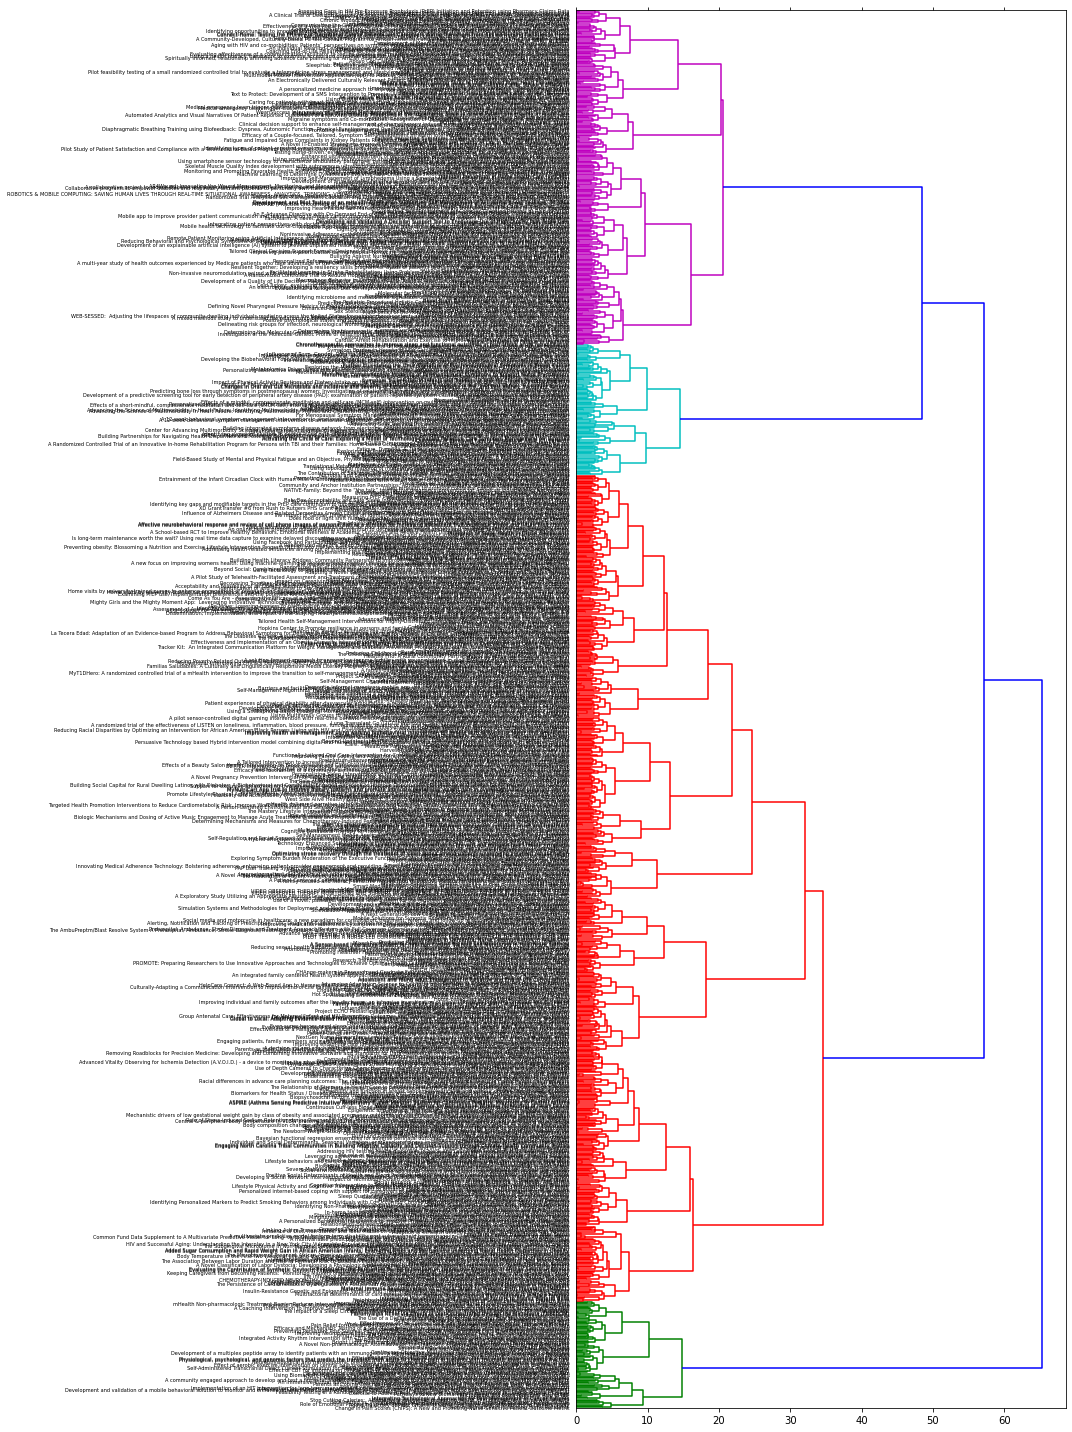

In [65]:
titles = ninr19['Title'].to_list()

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [sno.stem(t) for t in filtered_tokens]
    return stems

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(texts) #fit the vectorizer to text
dist = 1 - cosine_similarity(tfidf_matrix)

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right",labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_cluster